# F1 Ground Effect LBM Simulation - Main Notebook

This notebook implements a Lattice Boltzmann Method (LBM) simulation to study turbulent flow transitions in F1 ground-effect aerodynamics.

## Project Structure
- **Phase 1**: Minimal Viable Simulation (MVS) - Validation with Poiseuille flow
- **Phase 2**: Cylinder flow and Reynolds number sweep
- **Phase 3**: F1 wing proxy and turbulence analysis
- **Phase 4**: Advanced visualization and scaling

## Team Members
Alfonso Gondro Ostos, Ricardo Carvalho Ribeiro, Nicholas Miot, Xiaoduo Zhuo

## Setup and Imports

In [2]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import yaml
import sys
from pathlib import Path

# Add src to path
sys.path.append('../src')

# Import our modules
from lbm_core import LBMSimulation, D2Q9Lattice
from boundary_conditions import apply_all_boundaries, BoundaryConditions
from geometry import create_cylinder, create_f1_wing_proxy
from validation import validate_poiseuille, mass_conservation_check
from analysis import ConvergenceMonitor, calculate_tke, calculate_drag_coefficient
from visualization import (plot_velocity_field, plot_vorticity, plot_streamlines,
                          plot_velocity_profile, plot_convergence_history,
                          plot_comparison_panel)

# Matplotlib settings
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

print("✓ All imports successful")

✓ All imports successful


## Load Configuration

In [16]:
# Load configuration
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(f"  Domain: {config['domain']['nx']} x {config['domain']['ny']}")
print(f"  Reynolds numbers: {config['physics']['reynolds_numbers']}")
print(f"  Max iterations: {config['simulation']['max_iterations']}")
print(f"  Bottom boundary: {config['boundaries']['bottom_type']}")

Configuration loaded:
  Domain: 400 x 100
  Reynolds numbers: [100, 500, 1000, 2000]
  Max iterations: 20000
  Bottom boundary: slip


---
# Phase 1: Minimal Viable Simulation (MVS)

Goal: Validate the LBM implementation against analytical solutions for Poiseuille (channel) flow.

## 1.1 Setup Poiseuille Flow

Poiseuille flow is fully-developed laminar flow between two parallel plates. The analytical solution is:

$$u(y) = u_{max} \left[1 - \left(\frac{y - y_{center}}{y_{center}}\right)^2\right]$$

This provides a perfect test case for our LBM implementation.

In [4]:
# Parameters for Poiseuille flow
nx = config['domain']['nx']
ny = config['domain']['ny']
Re = 100  # Start with low Reynolds number
u_max = config['physics']['u_max']

# Create simulation
print("Initializing Poiseuille flow simulation...")
sim_poiseuille = LBMSimulation(nx=nx, ny=ny, reynolds_number=Re, u_max=u_max)

# Initialize with parabolic velocity profile
y = np.arange(ny)
y_center = (ny - 1) / 2.0
u_init = u_max * (1 - ((y - y_center) / y_center)**2)
u_field = np.zeros((2, nx, ny))
u_field[0, :, :] = u_init[np.newaxis, :]

sim_poiseuille.initialize_equilibrium(rho_init=1.0, u_init=u_field)

print(f"✓ Simulation initialized")
print(f"  Reynolds number: {Re}")
print(f"  Kinematic viscosity: {sim_poiseuille.nu:.6f}")
print(f"  Relaxation time τ: {sim_poiseuille.tau:.6f}")

Initializing Poiseuille flow simulation...
✓ Simulation initialized
  Reynolds number: 100
  Kinematic viscosity: 0.050000
  Relaxation time τ: 0.650000


## 1.2 Run Poiseuille Simulation

In [5]:
# Setup convergence monitoring
monitor_poiseuille = ConvergenceMonitor(window_size=500)

# Run simulation
print("Running Poiseuille flow simulation...")
n_steps = 5000
checkpoint = 100

for step in range(n_steps):
    # Apply boundary conditions (no-slip top and bottom for Poiseuille)
    bc = BoundaryConditions(sim_poiseuille)
    bc.apply_no_slip_bottom()
    bc.apply_slip_top()  # Or no-slip for both walls
    bc.apply_periodic_x()  # Periodic in flow direction
    
    # LBM step
    sim_poiseuille.step()
    
    # Monitor convergence
    if step % checkpoint == 0:
        vel_mag = sim_poiseuille.get_velocity_magnitude()
        monitor_poiseuille.update(vel_mag)
        
        # Check for steady state
        if monitor_poiseuille.is_steady_state():
            print(f"  Steady state reached at iteration {step}")
            break
        
        if step % 1000 == 0:
            stats = monitor_poiseuille.get_statistics()
            print(f"  Step {step}: mean_vel = {stats['current_mean_velocity']:.6f}, "
                  f"variance = {stats['current_variance']:.2e}")

print(f"✓ Simulation complete at iteration {sim_poiseuille.iteration}")

Running Poiseuille flow simulation...
  Step 0: mean_vel = 0.032997, variance = 0.00e+00
  Step 1000: mean_vel = 0.031191, variance = 3.48e-07
  Step 2000: mean_vel = 0.029568, variance = 1.17e-06
  Step 3000: mean_vel = 0.028062, variance = 2.40e-06
  Step 4000: mean_vel = 0.026651, variance = 3.95e-06
✓ Simulation complete at iteration 5000


## 1.3 Validate Against Analytical Solution

In [6]:
# Validate results
validation_results = validate_poiseuille(sim_poiseuille, u_max, sample_x=nx//2)

print("Validation Results:")
print(f"  L2 Error: {validation_results['l2_error']:.2e}")
print(f"  Relative Error: {validation_results['relative_error']:.2%}")

# Check mass conservation
total_mass = mass_conservation_check(sim_poiseuille)
expected_mass = 1.0 * nx * ny  # rho=1.0 initially
print(f"  Mass conservation: {total_mass:.6f} (expected: {expected_mass:.6f})")
print(f"  Mass error: {abs(total_mass - expected_mass)/expected_mass:.2e}")

Validation Results:
  L2 Error: 8.18e-03
  Relative Error: 16.35%
  Mass conservation: 40000.000000 (expected: 40000.000000)
  Mass error: 4.15e-13


## 1.4 Visualize Results

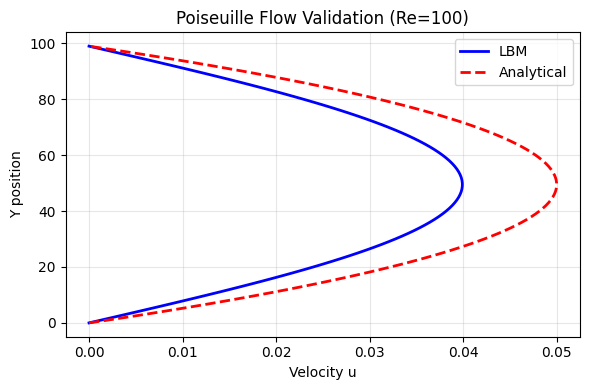

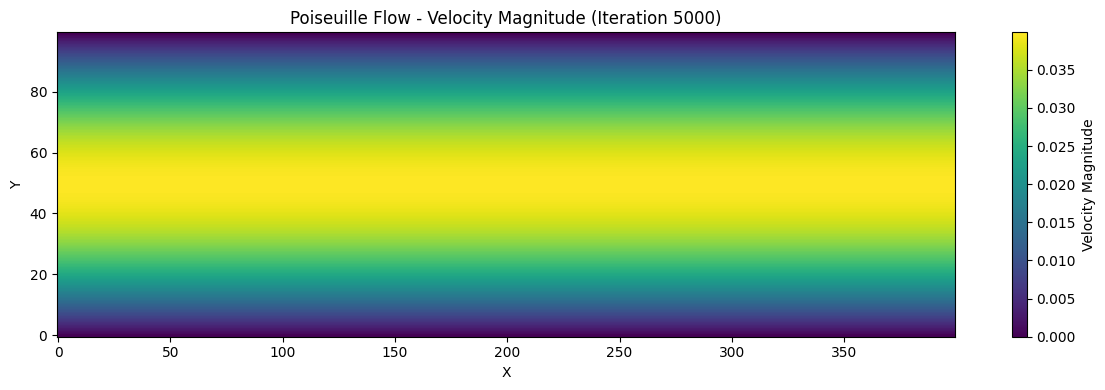

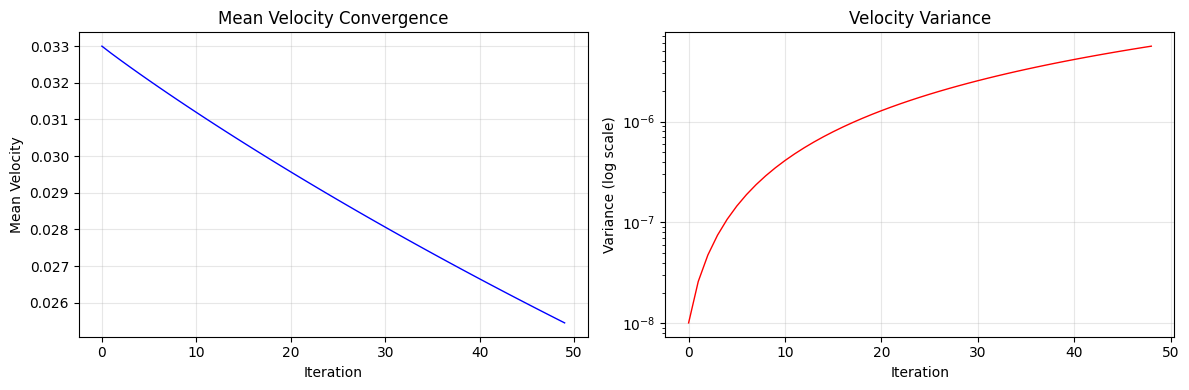

In [7]:
# Plot velocity profile comparison
y_coords = np.arange(ny)
plot_velocity_profile(
    y_coords,
    validation_results['u_numerical'],
    validation_results['u_analytical'],
    title=f"Poiseuille Flow Validation (Re={Re})"
)
plt.show()

# Plot velocity field
plot_velocity_field(sim_poiseuille, title="Poiseuille Flow - Velocity Magnitude")
plt.show()

# Plot convergence history
plot_convergence_history(monitor_poiseuille)
plt.show()

---
# Phase 2: Cylinder Flow - Reynolds Number Sweep

Goal: Test the simulation with a cylinder obstacle and sweep Reynolds numbers to observe the transition from steady to unsteady (vortex shedding) flow.

Expected behavior:
- Re < 47: Steady flow
- Re > 47: Vortex shedding (Kármán vortex street)
- Re > 200: Transition toward turbulence

## 2.1 Setup Cylinder Simulation

In [32]:
# Cylinder parameters from config
cylinder_config = config['geometry']['cylinder']
radius = cylinder_config['radius']
center = (cylinder_config['center_x'], cylinder_config['center_y'])

# Test Reynolds number
Re_cylinder = 1000  # Should show vortex shedding at 100

print(f"Setting up cylinder flow simulation")
print(f"  Cylinder: radius={radius}, center={center}")
print(f"  Reynolds number: {Re_cylinder}")

# Create simulation
sim_cylinder = LBMSimulation(nx=nx, ny=ny, reynolds_number=Re_cylinder, u_max=u_max)

# Create cylinder obstacle
cylinder_mask = create_cylinder(nx, ny, center, radius)
sim_cylinder.set_obstacle(cylinder_mask)

# Initialize with uniform flow
u_inlet = 0.05 # Changed from pulling directly from config file
u_field_cylinder = np.zeros((2, nx, ny))
u_field_cylinder[0, :, :] = u_inlet
sim_cylinder.initialize_equilibrium(rho_init=1.0, u_init=u_field_cylinder)

print(f"✓ Cylinder simulation initialized")
print(f"  Obstacle nodes: {np.sum(cylinder_mask)}")

Setting up cylinder flow simulation
  Cylinder: radius=8, center=(80, 50)
  Reynolds number: 1000
✓ Cylinder simulation initialized
  Obstacle nodes: 197


## 2.2 Run Cylinder Simulation

In [33]:
# Setup monitoring
monitor_cylinder = ConvergenceMonitor(window_size=1000)

# Run simulation
print("Running cylinder flow simulation...")
n_steps_cylinder = 10000
checkpoint = 500

for step in range(n_steps_cylinder):
    # SIMPLIFIED boundary conditions - no Zou-He inlet
    bc_cylinder = BoundaryConditions(sim_cylinder)
    
    # Manual simple inlet - just maintain velocity
    sim_cylinder.u[0, 0:2, :] = u_inlet  # First 2 columns
    sim_cylinder.u[1, 0:2, :] = 0
    sim_cylinder.rho[0:2, :] = 1.0
    
    # Simple outlet - just copy from interior
    sim_cylinder.u[:, -1, :] = sim_cylinder.u[:, -2, :]
    sim_cylinder.rho[-1, :] = 1.0
    
    # Apply slip walls
    bc_cylinder.apply_slip_bottom()
    bc_cylinder.apply_slip_top()
    
    # LBM step
    sim_cylinder.step()
    
    # Monitor
    if step % checkpoint == 0:
        # Only measure in fluid region
        fluid_mask = ~sim_cylinder.obstacle
        vel_mag = sim_cylinder.get_velocity_magnitude()
        vel_mag_fluid = vel_mag[fluid_mask]
        
        mean_vel = np.mean(vel_mag_fluid)
        variance = np.var(vel_mag_fluid)
        max_vel = np.max(vel_mag_fluid)
        
        print(f"  Step {step}: mean_vel = {mean_vel:.6f}, "
              f"variance = {variance:.2e}, max_vel = {max_vel:.6f}")
        
        # Check for divergence
        if np.isnan(mean_vel) or max_vel > 0.5:
            print(f"  ✗ DIVERGED at step {step}!")
            print(f"     Reduce u_inlet or Re further")
            break
        
        # Update monitor
        monitor_cylinder.update(vel_mag)
        
        # Check for transition
        if monitor_cylinder.detect_transition():
            print(f"  ⚠ Transition detected at iteration {step}!")
else:
    print(f"✓ Cylinder simulation complete")

Running cylinder flow simulation...
  Step 0: mean_vel = 0.049665, variance = 5.47e-06, max_vel = 0.050000
  Step 500: mean_vel = 0.047146, variance = 9.31e-05, max_vel = 0.079052
  Step 1000: mean_vel = 0.046143, variance = 1.14e-04, max_vel = 0.075592
  Step 1500: mean_vel = 0.045351, variance = 1.27e-04, max_vel = 0.072073
  Step 2000: mean_vel = 0.044577, variance = 1.43e-04, max_vel = 0.070884
  Step 2500: mean_vel = 0.043845, variance = 1.60e-04, max_vel = 0.073170
  Step 3000: mean_vel = 0.043261, variance = 1.65e-04, max_vel = 0.073165
  Step 3500: mean_vel = 0.042598, variance = 1.79e-04, max_vel = 0.073102
  Step 4000: mean_vel = 0.042080, variance = 1.80e-04, max_vel = 0.072351
  Step 4500: mean_vel = 0.041551, variance = 1.83e-04, max_vel = 0.074410
  Step 5000: mean_vel = 0.041015, variance = 1.87e-04, max_vel = 0.075616
  Step 5500: mean_vel = 0.040520, variance = 1.88e-04, max_vel = 0.076621
  Step 6000: mean_vel = 0.040022, variance = 1.90e-04, max_vel = 0.077750
  Step

## 2.3 Visualize Cylinder Flow

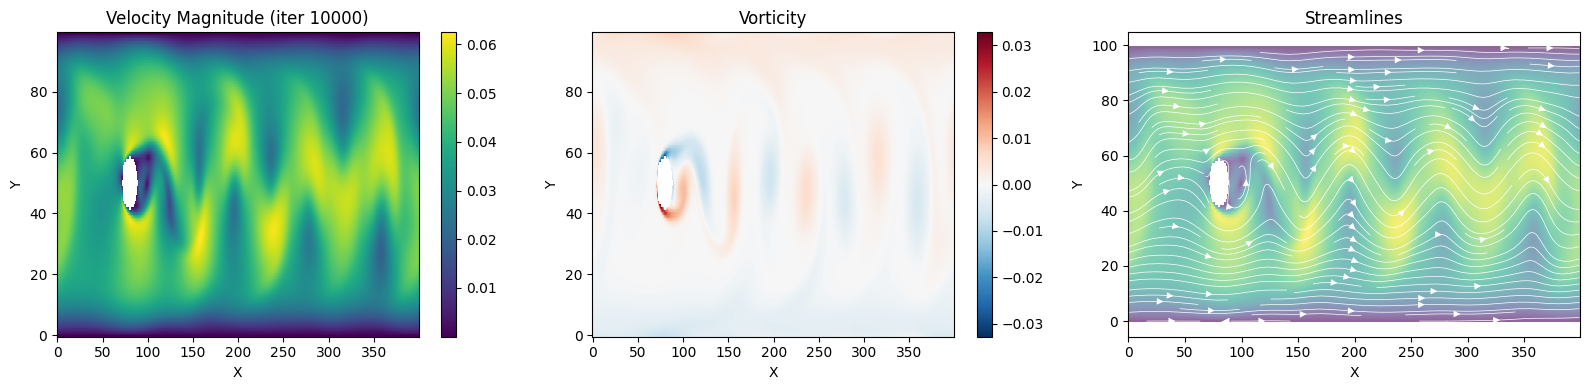

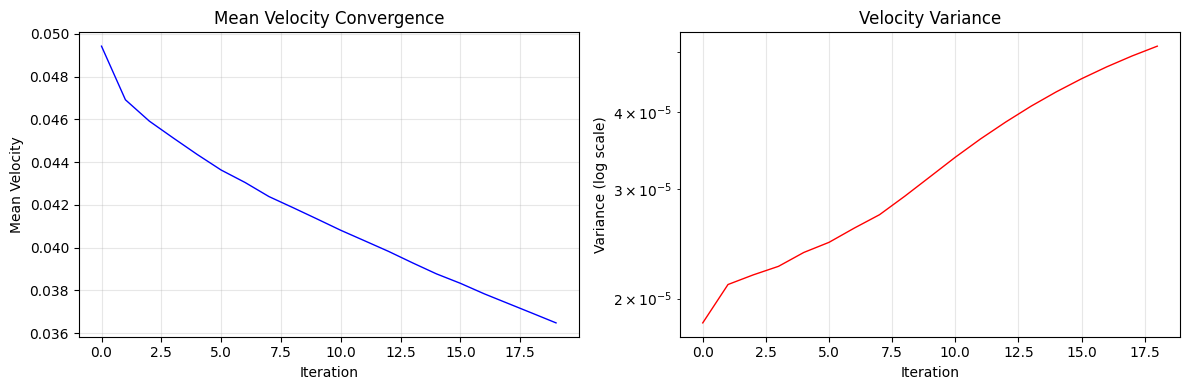

In [34]:
# Create comprehensive visualization
plot_comparison_panel(sim_cylinder)
plt.savefig('../visualizations/cylinder_flow_Re{}.png'.format(Re_cylinder))
plt.show()

# Plot convergence
plot_convergence_history(monitor_cylinder)
plt.show()

---
# Phase 3: F1 Wing Proxy - Ground Effect Study

Goal: Simulate flow around a simplified F1 front wing near the ground, studying:
1. Effect of ride height on downforce
2. Transition to turbulent flow
3. Difference between slip vs no-slip ground boundary

## 3.1 Setup F1 Wing Simulation

In [38]:
# Wing parameters from config
wing_config = config['geometry']['wing']
chord = wing_config['chord']
ride_height = wing_config['ride_height']
angle = wing_config['angle_of_attack']

# Reynolds number for wing
Re_wing = 500

print(f"Setting up F1 wing simulation")
print(f"  Wing: chord={chord}, ride_height={ride_height}, AoA={angle}°")
print(f"  Reynolds number: {Re_wing}")
print(f"  Bottom boundary: {config['boundaries']['bottom_type']}")

# Create simulation
sim_wing = LBMSimulation(nx=nx, ny=ny, reynolds_number=Re_wing, u_max=u_max)

# Create wing geometry
wing_mask = create_f1_wing_proxy(
    nx, ny,
    chord=chord,
    ride_height=ride_height,
    angle_of_attack=angle,
    x_position=wing_config['x_position']
)
sim_wing.set_obstacle(wing_mask)

# Initialize
u_field_wing = np.zeros((2, nx, ny))
u_field_wing[0, :, :] = u_max
sim_wing.initialize_equilibrium(rho_init=1.0, u_init=u_field_wing)

print(f"✓ Wing simulation initialized")
print(f"  Wing nodes: {np.sum(wing_mask)}")

Setting up F1 wing simulation
  Wing: chord=50, ride_height=15, AoA=5.0°
  Reynolds number: 500
  Bottom boundary: slip
✓ Wing simulation initialized
  Wing nodes: 350


## 3.2 Run F1 Wing Simulation

In [49]:
# Setup monitoring
monitor_wing = ConvergenceMonitor(window_size=1000)

# Run simulation
print("Running F1 wing simulation...")
n_steps_wing = 15000
checkpoint = 500

# Parameters
Re_wing = 2000      
u_inlet_wing = 0.04  
nx = 800 # Moved from config file
ny = 200 # Moved from config file

print(f"Using STABLE parameters: Re={Re_wing}, u_inlet={u_inlet_wing}")

# Recreate simulation with safe parameters
sim_wing = LBMSimulation(nx=nx, ny=ny, reynolds_number=Re_wing, u_max=u_inlet_wing)

# Recreate wing with these safer settings
wing_mask = create_f1_wing_proxy(
    nx, ny,
    chord=chord,
    ride_height=ride_height,
    angle_of_attack=angle,
    x_position=wing_config['x_position']
)
sim_wing.set_obstacle(wing_mask)

# Initialize
u_field_wing = np.zeros((2, nx, ny))
u_field_wing[0, :, :] = u_inlet_wing
sim_wing.initialize_equilibrium(rho_init=1.0, u_init=u_field_wing)

print(f"Ride height: {ride_height}, Angle: {angle}°")
print(f"Wing nodes: {np.sum(wing_mask)}")

# Run with SIMPLE boundaries (like cylinder)
for step in range(n_steps_wing):
    bc_wing = BoundaryConditions(sim_wing)
    
    # Simple inlet
    sim_wing.u[0, 0:2, :] = u_inlet_wing
    sim_wing.u[1, 0:2, :] = 0
    sim_wing.rho[0:2, :] = 1.0
    
    # Simple outlet
    sim_wing.u[:, -1, :] = sim_wing.u[:, -2, :]
    sim_wing.rho[-1, :] = 1.0
    
    # Apply bottom boundary from config
    if config['boundaries']['bottom_type'] == 'slip':
        bc_wing.apply_slip_bottom()
    else:
        bc_wing.apply_no_slip_bottom()
    
    bc_wing.apply_slip_top()
    
    # LBM step
    sim_wing.step()
    
    # Monitor
    if step % checkpoint == 0:
        fluid_mask = ~sim_wing.obstacle
        vel_mag = sim_wing.get_velocity_magnitude()
        vel_mag_fluid = vel_mag[fluid_mask]
        
        mean_vel = np.mean(vel_mag_fluid)
        variance = np.var(vel_mag_fluid)
        max_vel = np.max(vel_mag_fluid)
        
        print(f"  Step {step}: mean_vel = {mean_vel:.6f}, "
              f"variance = {variance:.2e}, max_vel = {max_vel:.6f}")
        
        # Check for divergence
        if np.isnan(mean_vel) or max_vel > 0.3:
            print(f"  ✗ DIVERGED at step {step}!")
            print(f"     Ground effect creates high velocities")
            print(f"     Try: smaller angle, higher ride_height, or lower u_inlet")
            break
        
        monitor_wing.update(vel_mag)
        
        if monitor_wing.detect_transition(threshold=1e-5):
            print(f"  ⚠ Turbulent transition detected at iteration {step}!")
else:
    print(f"✓ Wing simulation complete")

Running F1 wing simulation...
Using STABLE parameters: Re=2000, u_inlet=0.04
Ride height: 15, Angle: 5.0°
Wing nodes: 350
  Step 0: mean_vel = 0.039866, variance = 1.76e-06, max_vel = 0.040000
  Step 500: mean_vel = 0.039045, variance = 2.61e-05, max_vel = 0.064412
  Step 1000: mean_vel = 0.038727, variance = 3.27e-05, max_vel = 0.061932
  Step 1500: mean_vel = 0.038481, variance = 3.73e-05, max_vel = 0.057141
  Step 2000: mean_vel = 0.038263, variance = 4.17e-05, max_vel = 0.057009
  Step 2500: mean_vel = 0.038071, variance = 4.54e-05, max_vel = 0.055238
  Step 3000: mean_vel = 0.037901, variance = 4.82e-05, max_vel = 0.052725
  Step 3500: mean_vel = 0.037734, variance = 5.17e-05, max_vel = 0.052931
  Step 4000: mean_vel = 0.037581, variance = 5.45e-05, max_vel = 0.051977
  Step 4500: mean_vel = 0.037439, variance = 5.70e-05, max_vel = 0.049545
  Step 5000: mean_vel = 0.037300, variance = 5.97e-05, max_vel = 0.049253
  Step 5500: mean_vel = 0.037167, variance = 6.22e-05, max_vel = 0.0

## 3.3 Analyze Results

In [50]:
# Calculate forces (simplified)
from analysis import calculate_forces_momentum_exchange

force_x, force_y = calculate_forces_momentum_exchange(sim_wing, wing_mask)

# Calculate coefficients
C_D = calculate_drag_coefficient(force_x, rho=1.0, u_inlet=u_max, characteristic_length=chord)
C_L = calculate_drag_coefficient(force_y, rho=1.0, u_inlet=u_max, characteristic_length=chord)

print(f"\nAerodynamic Coefficients:")
print(f"  Drag coefficient C_D: {C_D:.4f}")
print(f"  Lift coefficient C_L: {C_L:.4f}")
print(f"  Downforce (negative lift): {-force_y:.4f}")

# Calculate TKE if we have variance
if len(monitor_wing.variance_history) > 100:
    print(f"\nTurbulence Indicators:")
    print(f"  Final variance: {monitor_wing.variance_history[-1]:.2e}")
    print(f"  Max variance: {max(monitor_wing.variance_history):.2e}")


Aerodynamic Coefficients:
  Drag coefficient C_D: 18.2448
  Lift coefficient C_L: -18.2448
  Downforce (negative lift): 1.1403


## 3.4 Visualize Wing Flow

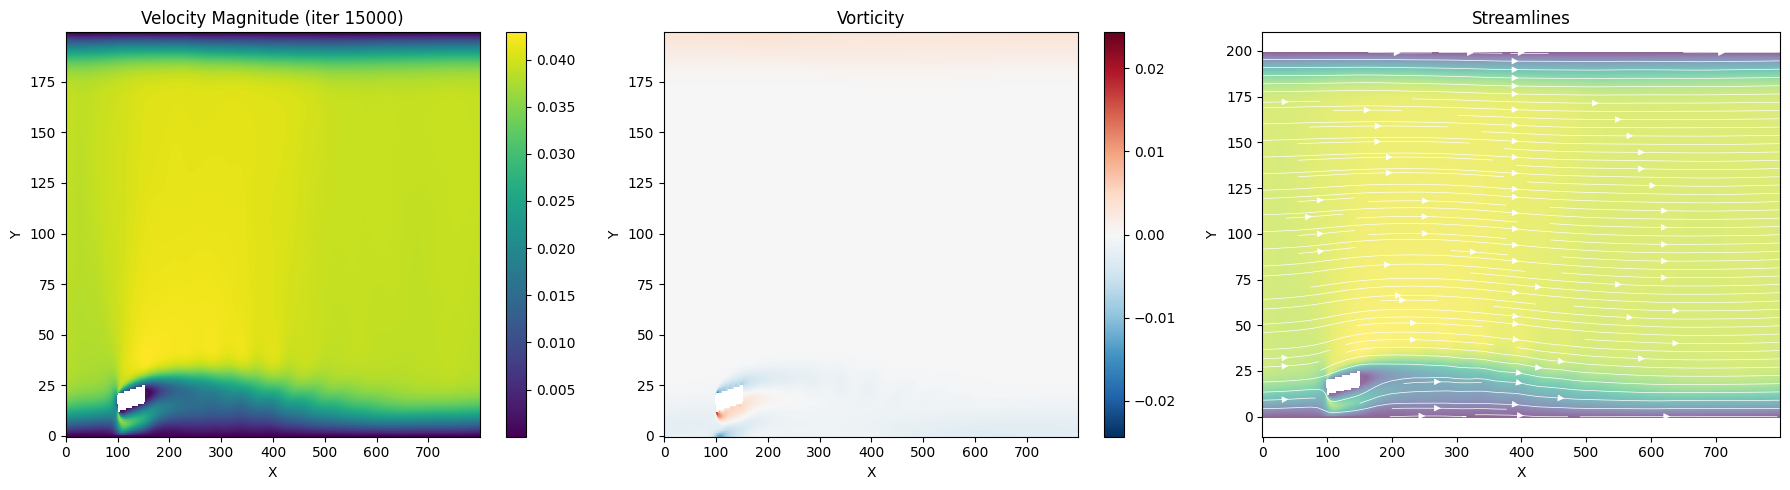

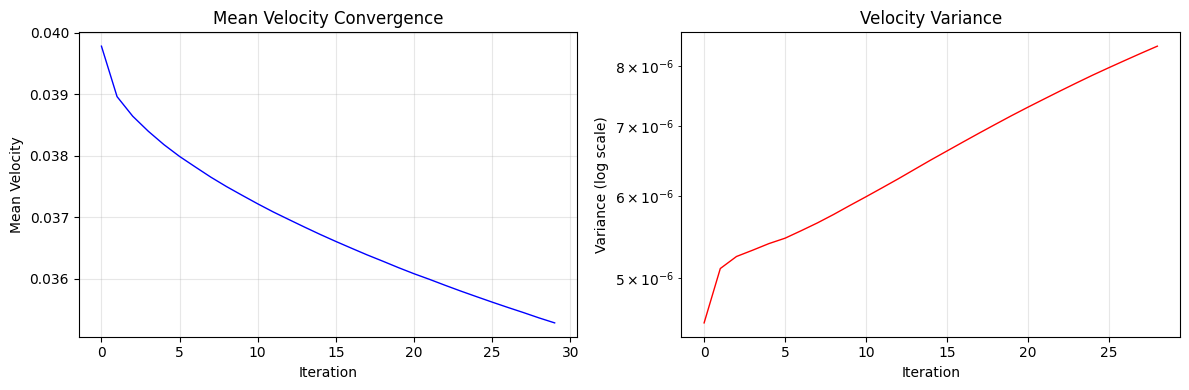

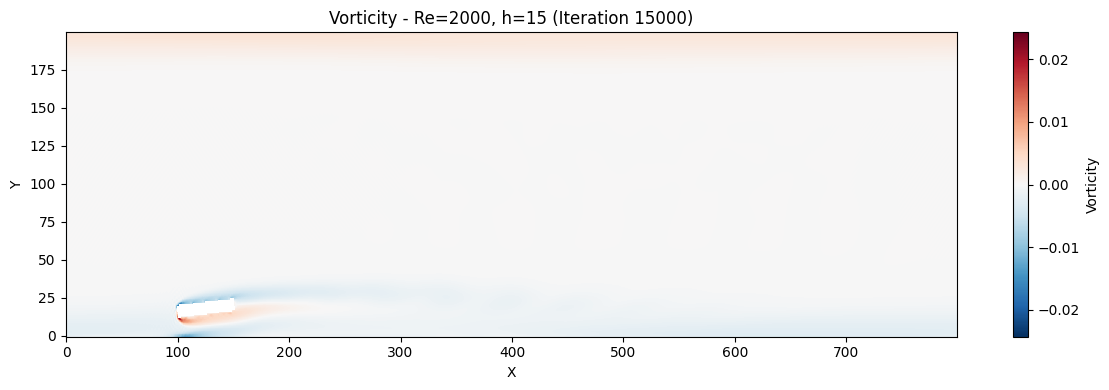

In [51]:
# Comprehensive visualization
plot_comparison_panel(sim_wing, figsize=(18, 5))
plt.savefig(f'../visualizations/wing_flow_Re{Re_wing}_h{ride_height}_{bottom_boundary}.png')
plt.show()

# Convergence history
plot_convergence_history(monitor_wing)
plt.savefig('../visualizations/wing_convergence.png')
plt.show()

# Detailed vorticity
plot_vorticity(sim_wing, title=f"Vorticity - Re={Re_wing}, h={ride_height}")
plt.savefig('../visualizations/wing_vorticity.png')
plt.show()

---
# Phase 4: Parameter Sweep and Comparison

Goal: Systematically vary Reynolds number and ride height to map the parameter space.

In [ ]:
# This cell demonstrates how to run a parameter sweep
# For the full project, this would be expanded significantly

print("Parameter Sweep Example")
print("=" * 50)

# Define parameter ranges
Re_values = [100, 500, 1000]
ride_heights = [10, 15, 20]

results_matrix = []

print(f"\nWould run {len(Re_values) * len(ride_heights)} simulations")
print(f"  Reynolds numbers: {Re_values}")
print(f"  Ride heights: {ride_heights}")
print(f"\nEach simulation: ~{n_steps_wing} iterations")
print(f"Total computational cost: Significant - consider using Snellius")

# Example structure for parameter sweep:
# for Re in Re_values:
#     for h in ride_heights:
#         # Create simulation
#         # Run simulation
#         # Save results
#         # results_matrix.append({'Re': Re, 'h': h, 'C_L': C_L, ...})

---
# Summary and Next Steps

## What We've Built:
1. ✓ Core LBM implementation (D2Q9 lattice)
2. ✓ Boundary conditions (slip, no-slip, inlet, outlet)
3. ✓ Validation against Poiseuille flow
4. ✓ Cylinder flow for turbulence testing
5. ✓ F1 wing proxy with ground effect
6. ✓ Convergence monitoring and turbulence detection
7. ✓ Comprehensive visualization tools

## Next Steps:
1. Run full parameter sweeps (Re vs ride height)
2. Compare slip vs no-slip ground boundary
3. Implement more sophisticated force calculations
4. Generate animations of vortex shedding
5. Analyze bifurcation points
6. Create presentation figures

## For Production Runs:
- Increase grid resolution (nx=800, ny=200)
- Run longer simulations (50,000+ iterations)
- Use Snellius for computational scaling
- Implement checkpointing for long runs